<a href="https://colab.research.google.com/github/lauralpezb/CleaningDataPython/blob/main/Cleaning_Data_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

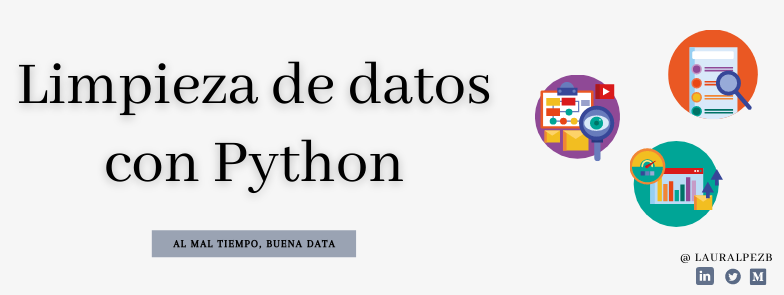

In [125]:
from IPython.display import Image 
Image(filename='/content/Banners post blog.png', width=1200)

#  🧹 Limpieza de datos con Python Parte 2

__Contenido:__
- Uniformidad de los datos
- Valores nulos 
- Comparación de caracteres 

---
Este notebook es la continuación de [Cleaning data Python](https://github.com/SandyAtencio/Cleaning_data_Python_Part_1) basado en el curso de DataCamp [Cleaning Data in Python](https://learn.datacamp.com/courses/cleaning-data-in-python)

La limpieza de datos es una de las partes más importantes en un proyecto de datos, si no tienes datos limpios los análisis que realices y los modelos que implementes tendrán malos resultados. La mayor parte del tiempo de un proyecto con datos se usa en entender los datos y verificar que estén correctos, con esto se obtienen los datos que necesitamos para realizar análisis descriptivos y modelamiento, de este proceso depende el exito y claridad de los resultados que obtenemos al final. 

Así que, ¡manos a la obra!

📑 **Importar librerías** 

In [126]:
!pip install fuzzywuzzy

In [127]:
import pandas as pd #Manejo de dataframe
import matplotlib.pyplot as plt #Visualización
import datetime as dt #Manejo de fechas
import missingno as msno #Visualización de nan
from fuzzywuzzy import fuzz #Comparar cadenas de caracteres

## **Uniformidad en los datos**

Nuestros datos pueden tomar diferentes valores, por lo general a cada columna le definimos un rango y formato para que exista uniformidad. 
Cuando estamos explorando un dataframe podemos encontrar:
- Valores fuera de los rangos establecidos
- Fechas de registros o datos mayores a la actual

Vamos a crear un dataframe donde daremos solución a estos inconvenientes.

In [128]:
#Crear dataframe
temperatura = {'Date':['03.06.21','04-06-21','05.06.21','06/06/21','17.16.21'],
               'Temperature':[14.0,17.0,20.0,15.0,65.0]} 
temp = pd.DataFrame(temperatura)

Podemos revisar el comportamiento de nuestros datos usando *describe()* o con ayuda de una gráfica:

       Temperature
count     5.000000
mean     26.200000
std      21.810548
min      14.000000
25%      15.000000
50%      17.000000
75%      20.000000
max      65.000000


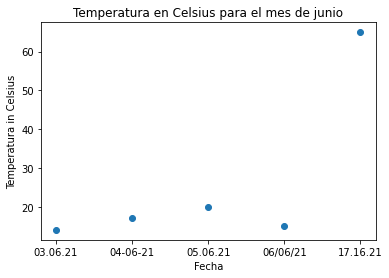

In [129]:
#Descripción de los valores numéricos
print(temp.describe())

# Visualización 
plt.scatter(x = 'Date', y = 'Temperature', data = temp)
plt.title('Temperatura en Celsius para el mes de junio')
plt.xlabel('Fecha')
plt.ylabel('Temperatura in Celsius')
plt.show()

Podemos observar un dato atipico, con valor de 65°C

Este pudo ser un error de conversión de datos, puede estar en °F y vamos a pasarlo a °C:

$C = (F - 32) * (5/9) $

In [130]:
#Convertir °F a °C
temp_f = temp.loc[temp['Temperature'] > 40, 'Temperature']
temp_c = (temp_f - 32) *(5/9)
temp.loc[temp['Temperature'] > 40, 'Temperature'] = temp_c
temp

,Date,Temperature
0,03.06.21,14.000000
1,04-06-21,17.000000
2,05.06.21,20.000000
3,06/06/21,15.000000
4,17.16.21,18.333333


Ahora podemos observar que la fecha tiene diferentes formatos y eso nos impide extraer informacion como año y mes de forma adecuada.
Para convertir la fecha a un único formato:

In [131]:
temp['Date'] = pd.to_datetime(temp['Date'])
temp

ParserError: ignored

En este caso ocurre un error porque tenemos el valor 17.16.21 que no coincide con los valores permitidos para mes.

En este caso tenemos dos alternativas para solucionarlo:

In [132]:
#1 Inferir el formato de la fecha y poner NA si ocurre un error
temp['Date'] = pd.to_datetime(temp['Date'], infer_datetime_format=True, errors = 'coerce')

#2 Definir el formato de la fecha, los que no cumplen serán NA
temp['Date'] = temp['Date'].dt.strftime("%d-%m-%Y")

temp

,Date,Temperature
0,06-03-2021,14.000000
1,06-04-2021,17.000000
2,06-05-2021,20.000000
3,06-06-2021,15.000000
4,NaN,18.333333


**Validación de datos**

Podemos validar datos que surgen de realizar alguna operación entre columnas, incluso si tenemos información de clientes o personas como su fecha de nacimiento podemos validar si el campo de edad es correcto.

In [133]:
#Crear dataframe
supermercado = {'Cliente':['AD298','AGE296','DSP286','PTU107','TWJ108'],
               'Verduras':[14900,17550,27300,15400,42200],
               'Lacteos':[45000,32900,28000,15700,69200],
               'Carnes':[65900,26700,28900,41700,61800],
               'Total':[125800,87650,84200,72800,173200],
               'AnnioIngreso':['2019','2017','2021','2020','2021'],
               'Antiguedad':[2,4,0,1,0]} 
super = pd.DataFrame(supermercado)

Vamos a verificar que para el supermercado **Super** las ventas totales sean igual a la suma del valor de los productos que llevan sus clientes por cada categoria (verduras, lacteos y carnes)

In [134]:
sum_compras = super[['Verduras', 'Lacteos', 'Carnes']].sum(axis = 1) #Sumar los valores de las filas
total_compras = sum_compras == super['Total'] #Validar si el campo Total es igual a la suma de los demás campos
# Encontrar y filtrar columnas inconsistentes 
inconsistencias = super[~total_compras]
consistencias = super[total_compras]
print('Datos inconsistentes: \n', inconsistencias)
print('\n')
print('Datos correctos: \n', consistencias)

Datos inconsistentes: 
   Cliente  Verduras  Lacteos  Carnes  Total AnnioIngreso  Antiguedad
1  AGE296     17550    32900   26700  87650         2017           4


Datos correctos: 
   Cliente  Verduras  Lacteos  Carnes   Total AnnioIngreso  Antiguedad
0   AD298     14900    45000   65900  125800         2019           2
2  DSP286     27300    28000   28900   84200         2021           0
3  PTU107     15400    15700   41700   72800         2020           1
4  TWJ108     42200    69200   61800  173200         2021           0


Vemos que para el segundo registro (indice 1) se ha calculado mal la suma del total. Cómo lo corregimos? Tenemos dos formas de hacerlo:

In [135]:
#Cambiar el valor especifico
super['Total'].iloc[1] = super[['Verduras','Lacteos','Carnes']].iloc[1].sum()
super['Total'].iloc[1]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


77150

In [136]:
#Cambiar todos los valores de la columna
super['Total'] = super[['Verduras','Lacteos','Carnes']].sum(axis=1)
super['Total']

0    125800
1     77150
2     84200
3     72800
4    173200
Name: Total, dtype: int64

Ahora vamos a validar si la cantidad de años de antiguedad corresponde a los años que se tienen almacenados, ya que con esto los administradores están pensando en crear descuentos.


In [137]:
super.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Cliente       5 non-null      object
 1   Verduras      5 non-null      int64 
 2   Lacteos       5 non-null      int64 
 3   Carnes        5 non-null      int64 
 4   Total         5 non-null      int64 
 5   AnnioIngreso  5 non-null      object
 6   Antiguedad    5 non-null      int64 
dtypes: int64(5), object(2)
memory usage: 408.0+ bytes


In [138]:
#Convertir campo a datetime
super['AnnioIngreso'] = pd.to_datetime(super['AnnioIngreso'], format="%Y")

Luego de cambiar el tipo de dato vamos a verificar que el tiempo de antiguedad esté correcto para todos los clientes y así lanzar la campaña de descuentos y evitar inconvenientes:

In [139]:
actual = dt.date.today() #Año actual
validar_antiguedad = actual.year - super['AnnioIngreso'].dt.year #Año actual menos año de ingreso para calcular antiguedad

antig = validar_antiguedad == super['Antiguedad']
#Encontrar inconsistencias
inconsistencias = super[~antig]
consistencias = super[antig]

print('Datos inconsistentes: \n', inconsistencias)
print('\n')
print('Datos correctos: \n', consistencias)

Datos inconsistentes: 
 Empty DataFrame
Columns: [Cliente, Verduras, Lacteos, Carnes, Total, AnnioIngreso, Antiguedad]
Index: []


Datos correctos: 
   Cliente  Verduras  Lacteos  Carnes   Total AnnioIngreso  Antiguedad
0   AD298     14900    45000   65900  125800   2019-01-01           2
1  AGE296     17550    32900   26700   77150   2017-01-01           4
2  DSP286     27300    28000   28900   84200   2021-01-01           0
3  PTU107     15400    15700   41700   72800   2020-01-01           1
4  TWJ108     42200    69200   61800  173200   2021-01-01           0


In [140]:
validar_antiguedad

0    2
1    4
2    0
3    1
4    0
Name: AnnioIngreso, dtype: int64

Listo! Los datos están correctos.

¿Qué hacemos cuando hay inconsistencia con los datos?

- Eliminar datos.
- Reemplazar los valores.
- Aplicar reglas como reemplazar por la media o por algún valor especifico si se tiene conocimiento del negocio.

## **Valores nulos**

A veces no tenemos todos los datos, y esto nos impide continuar con nuestro análisis e implementación de modelos. 
Los valores nulos pueden ser Nan, nan, 0, espacios, " "

Como primer paso debemos validar si nuestro dataset tiene datos nulos:

In [141]:
super.isna() 
#Muestra valores booleanos 

,Cliente,Verduras,Lacteos,Carnes,Total,AnnioIngreso,Antiguedad
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False


In [142]:
#Agregar dato nulo
super=super.append({'Cliente' : 'DFE389' , 'Verduras' : 1400, 'Lacteos' : 27300, 'Total':28700} , ignore_index=True)

In [143]:
#Cantidad de nulos por columna
super.isna().sum()

Cliente         0
Verduras        0
Lacteos         0
Carnes          1
Total           0
AnnioIngreso    1
Antiguedad      1
dtype: int64

Para visualizar valores nulos podemos usar la librería *missingno*

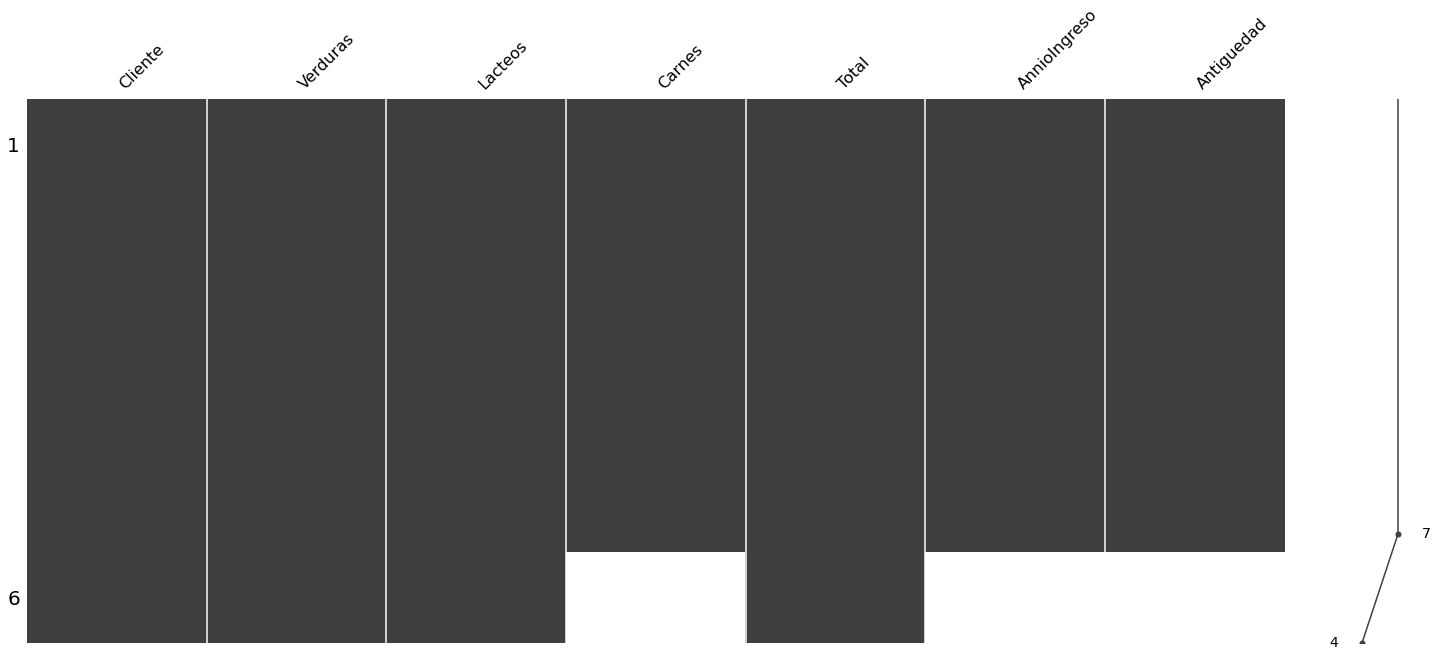

In [144]:
msno.matrix(super)
plt.show()

Al final podemos observar que los campos *Carnes*, AnnioIngreso y *Antiguedad* tienen datos nulos. Cuando tenemos este tipo de datos podemos eliminarlos o reemplazarlos con valores como media, moda o mediana.

In [145]:
#Eliminar nulos
super_nan = super.dropna(subset = ['Carnes'])
super_nan

,Cliente,Verduras,Lacteos,Carnes,Total,AnnioIngreso,Antiguedad
0,AD298,14900,45000,65900.0,125800,2019-01-01,2.0
1,AGE296,17550,32900,26700.0,77150,2017-01-01,4.0
2,DSP286,27300,28000,28900.0,84200,2021-01-01,0.0
3,PTU107,15400,15700,41700.0,72800,2020-01-01,1.0
4,TWJ108,42200,69200,61800.0,173200,2021-01-01,0.0


Para eliminarlo directamente en el dataframe *Super* usamos el parametro *inplace=True*

In [146]:
# En la línea anterior le asignamos a una nueva variable el valor del dataframe sin nulos
super

,Cliente,Verduras,Lacteos,Carnes,Total,AnnioIngreso,Antiguedad
0,AD298,14900,45000,65900.0,125800,2019-01-01,2.0
1,AGE296,17550,32900,26700.0,77150,2017-01-01,4.0
2,DSP286,27300,28000,28900.0,84200,2021-01-01,0.0
3,PTU107,15400,15700,41700.0,72800,2020-01-01,1.0
4,TWJ108,42200,69200,61800.0,173200,2021-01-01,0.0
5,DFE389,1400,27300,NaN,28700,NaT,NaN


In [147]:
#Reemplazar el valor de nan con 0 para una columna en especifico
super.fillna({'Carnes': 0}, inplace=True)
super

,Cliente,Verduras,Lacteos,Carnes,Total,AnnioIngreso,Antiguedad
0,AD298,14900,45000,65900.0,125800,2019-01-01,2.0
1,AGE296,17550,32900,26700.0,77150,2017-01-01,4.0
2,DSP286,27300,28000,28900.0,84200,2021-01-01,0.0
3,PTU107,15400,15700,41700.0,72800,2020-01-01,1.0
4,TWJ108,42200,69200,61800.0,173200,2021-01-01,0.0
5,DFE389,1400,27300,0.0,28700,NaT,NaN


In [148]:
#Reemplazar todos los nan con 0
super.fillna(0, inplace=True)
super

,Cliente,Verduras,Lacteos,Carnes,Total,AnnioIngreso,Antiguedad
0,AD298,14900,45000,65900.0,125800,2019-01-01 00:00:00,2.0
1,AGE296,17550,32900,26700.0,77150,2017-01-01 00:00:00,4.0
2,DSP286,27300,28000,28900.0,84200,2021-01-01 00:00:00,0.0
3,PTU107,15400,15700,41700.0,72800,2020-01-01 00:00:00,1.0
4,TWJ108,42200,69200,61800.0,173200,2021-01-01 00:00:00,0.0
5,DFE389,1400,27300,0.0,28700,0,0.0


Ahora tenemos nuestro dataframe sin datos nulos!

## **Comparación de caracteres**

En los datos podemos tener pequeñas diferencias o variaciones que pueden ser errores de digitación o modificaciones a los datos. Estos cambios pueden darse por varios motivos:

- Agregación
- Eliminación
- Sustitución
- Cambio de posición

Con ayuda de la librería *fuzzywuzzy* podemos realizar esta comparación y obtener un porcentaje de igualdad entre las cadenas.

Resulta que al supermercado llegó un cliente y su Id no está registrado pero es un cliente frecuente, esto puede ser un error en el dataframe, donde el Id del cliente fue alterado. Podemos ralizar una comparación con los Id para validar:

In [149]:
fuzz.WRatio('AGE296', 'AGF296')

83

In [150]:
super['Cliente'] = super['Cliente'].replace('AGE296', 'AGF296')
super

,Cliente,Verduras,Lacteos,Carnes,Total,AnnioIngreso,Antiguedad
0,AD298,14900,45000,65900.0,125800,2019-01-01 00:00:00,2.0
1,AGF296,17550,32900,26700.0,77150,2017-01-01 00:00:00,4.0
2,DSP286,27300,28000,28900.0,84200,2021-01-01 00:00:00,0.0
3,PTU107,15400,15700,41700.0,72800,2020-01-01 00:00:00,1.0
4,TWJ108,42200,69200,61800.0,173200,2021-01-01 00:00:00,0.0
5,DFE389,1400,27300,0.0,28700,0,0.0


Ta dá!

Tus datos están listos para inciar con análisis e implementación de modelos. 

"Si a un modelo le entra basura, sale basura"

Los datos por si solos no nos aportan mucho, es necesario realizar una exploración y limpieza para entenderlos, saber que información tenemos y como podemos usarla. Asimismo, tener datos de buena calidad no garantiza buenos modelos pero sin este proceso la tarea de modelamiento y análisis sería muy compleja y los resultados obtenidos no tendrían validez.